# Heart failure machine learning classication


### Import libraries

In [42]:
# import libraries
import numpy as np
import pandas as pd

# data visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

# useful data exploration libraries
from pandas_profiling import ProfileReport
import dabl

# ignore warnings
#import warnings
#warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once') # to see warnings once

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from imblearn.over_sampling import SMOTE
#import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#import catboost
from catboost import CatBoostClassifier

from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score

import time # to track how long the repeat_generations function takes to run

### Understand the data

In [2]:
# view first 5 rows
df = pd.read_csv('data/heart.csv')

In [3]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [4]:
df.shape

(918, 12)

In [5]:
# view data types of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
# summary of the numerical features and transpose to make it easier to read
df.describe().T

count        mean         std   min     25%    50%    75%    max
Age           918.0   53.510893    9.432617  28.0   47.00   54.0   60.0   77.0
RestingBP     918.0  132.396514   18.514154   0.0  120.00  130.0  140.0  200.0
Cholesterol   918.0  198.799564  109.384145   0.0  173.25  223.0  267.0  603.0
FastingBS     918.0    0.233115    0.423046   0.0    0.00    0.0    0.0    1.0
MaxHR         918.0  136.809368   25.460334  60.0  120.00  138.0  156.0  202.0
Oldpeak       918.0    0.887364    1.066570  -2.6    0.00    0.6    1.5    6.2
HeartDisease  918.0    0.553377    0.497414   0.0    0.00    1.0    1.0    1.0

In [7]:
# find out % of missing values for each column
missing_proportion = df.isnull().sum() / len(df) * 100
missing_proportion

Age               0.0
Sex               0.0
ChestPainType     0.0
RestingBP         0.0
Cholesterol       0.0
FastingBS         0.0
RestingECG        0.0
MaxHR             0.0
ExerciseAngina    0.0
Oldpeak           0.0
ST_Slope          0.0
HeartDisease      0.0
dtype: float64

### Understand the distribution of numerical columns and find potential outliers

Age


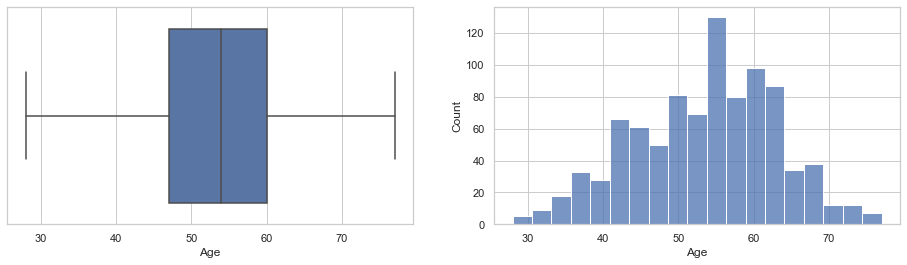

RestingBP


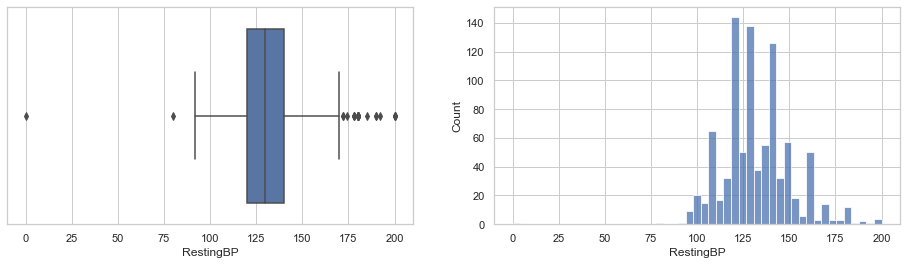

Cholesterol


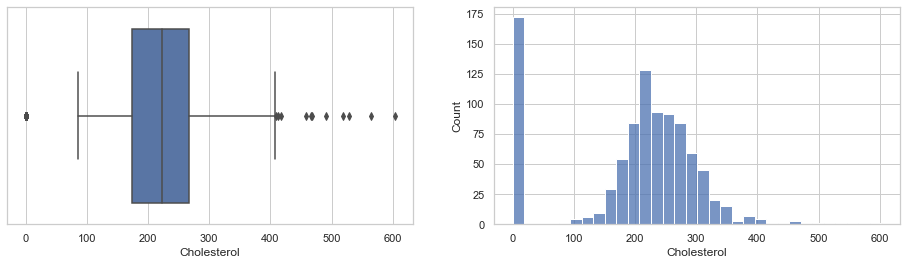

FastingBS


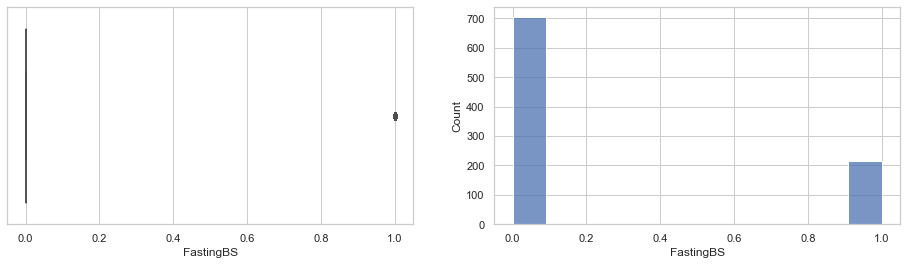

MaxHR


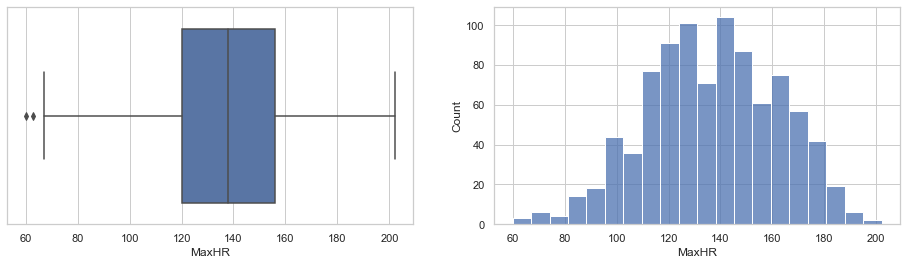

Oldpeak


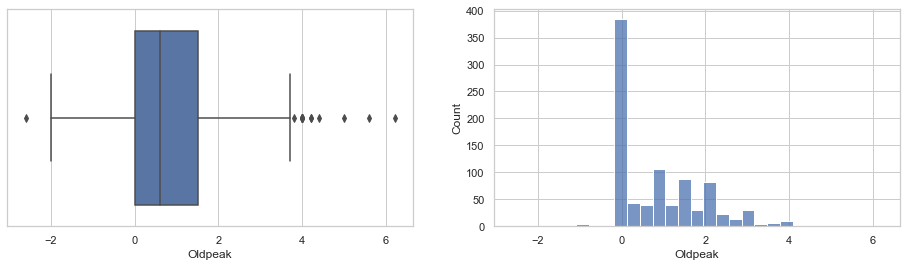

HeartDisease


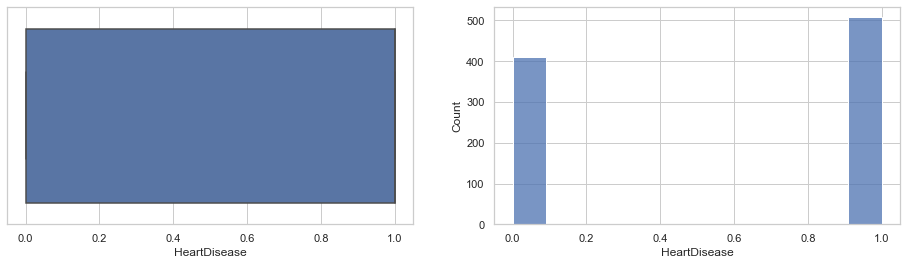

In [8]:
for colname, coltype in df.dtypes.iteritems():
    if (coltype == "float64") or (coltype == "int64"):
        print(colname)
        fig, ax = plt.subplots(1, 2, figsize=(16,4))
        sns.boxplot(data=df, x=colname, ax=ax[0])        
        sns.histplot(data=df, x=colname, ax=ax[1])
        plt.show()

In [9]:
# How unbalanced is the target feature?
heart_diseases  = df.groupby('HeartDisease').count().reset_index().iloc[:,1] / len(df)
heart_diseases


0    0.446623
1    0.553377
Name: Age, dtype: float64

## Quick EDA

In [10]:
profile = ProfileReport(df)

In [41]:
profile

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\supervised.py:546: FutureWarning: The second positional argument of plot is a Series 'y'. If passing a column name, use a keyword.
  warnings.warn("The second positional argument of plot is a Series 'y'."


Target looks like classification
Linear Discriminant Analysis training set score: 0.751


c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(
c:\Users\vinhe\anaconda3\lib\site-packages\dabl\plot\utils.py:374: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


[[<Figure size 1080x1080 with 30 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 432x288 with 1 Axes>],
 None]

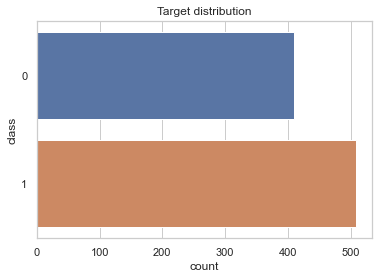

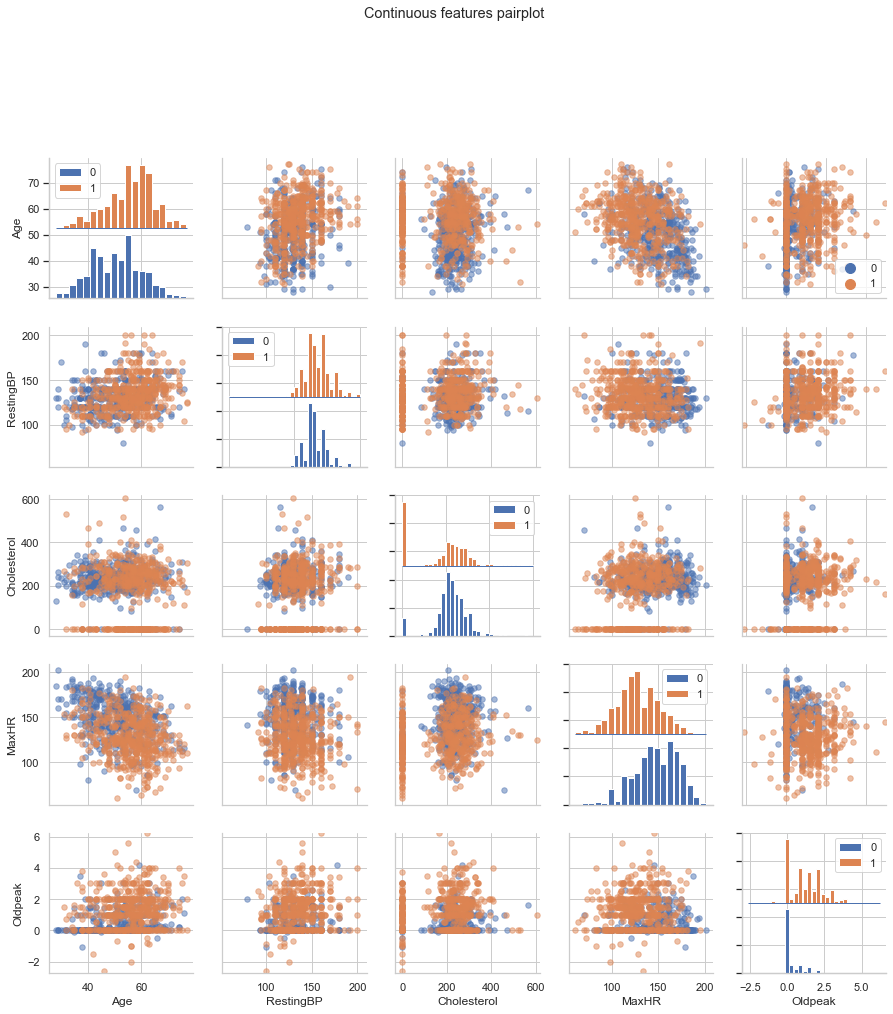

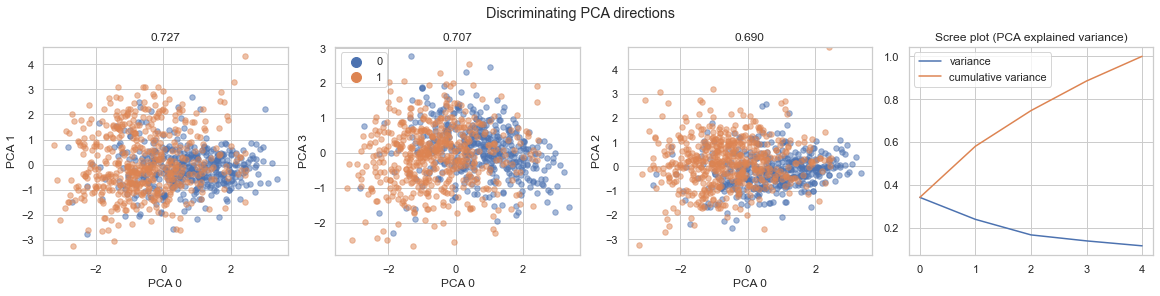

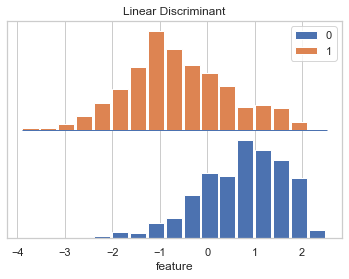

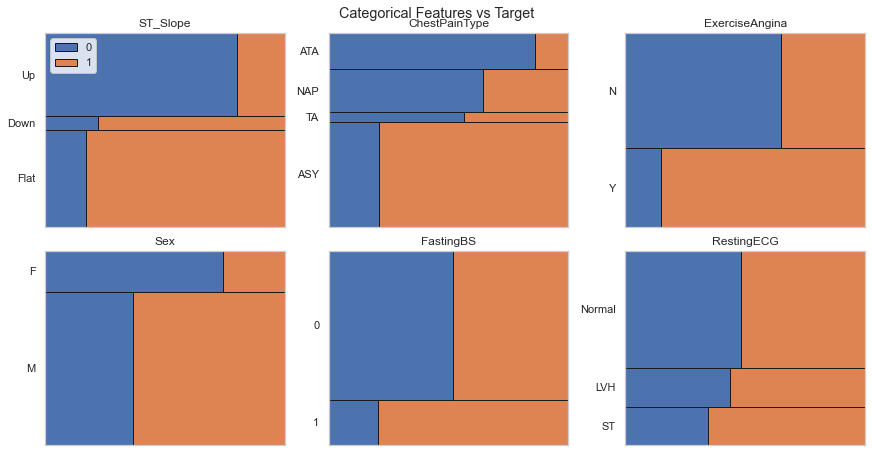

In [42]:
dabl.plot(df, "HeartDisease")

# Set baseline accuracy

In [11]:
# baseline accuracy, if we assumed every record was positive
base_line_accuracy = 1 - np.sum(df.HeartDisease)/df.shape[0]
base_line_accuracy

0.4466230936819172

# Process data to set benchmark machine learning

In [12]:
for colname, coltype in df.dtypes.iteritems():
    if coltype == "object":
        print(df[colname].unique())

['M' 'F']
['ATA' 'NAP' 'ASY' 'TA']
['Normal' 'ST' 'LVH']
['N' 'Y']
['Up' 'Flat' 'Down']


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [14]:
df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0

In [130]:
def get_dummies(df):
    '''
    Perform One Hot Encoding onto the dataset. Columns were not dropped to improve model explainability. 
    '''
    _cat_cols = df.select_dtypes(include=['object', 'category']).columns.to_list()
    _df_dummies = pd.get_dummies(df, columns=_cat_cols, drop_first=False)
    return _df_dummies

def split_data(df, _test_size=0.2, _random_state=0):
    '''
    Split dataset into train, test, split
    '''
    X = df.iloc[:, df.columns != 'HeartDisease']
    y = df['HeartDisease']

    # split X and y into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=_test_size, 
                                                        random_state=_random_state,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

def evaluate_models_once(X_train, X_test, y_train, y_test, models):
    '''
    Function to evaluate single instances of multiple machine learning models.
    '''
    for key, value in models.items():
        value.fit(X_train, y_train)
        _y_pred = value.predict(X_test)

        _confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, _y_pred),
            columns=["Predicted Survived", "Predicted Died"],
            index=["Survived", "Died"]) 

        _classification = classification_report(y_test, _y_pred)
        print(f"{key}------------------------------")
        print(f"Accuracy = {accuracy_score(y_test, _y_pred)}")
        print(f"Recall = {recall_score(y_test, _y_pred)}")
        print(f"Precision = {precision_score(y_test, _y_pred)}")
        print(f"F1 score = {f1_score(y_test, _y_pred)}")
        print(f"Classification report: \n {_classification}")
        print(f"Confusion matrix: \n {_confusion_matrix_df} \n")
        #print("------------------------------------------------------")

def stratified_kfolds_model_eval(X, y, models, _n_splits=5, _n_repeats=3):
    '''
    Apply stratified K-folds to models and evaluate them.
    '''
    # log number of seconds to run function
    start = time.time() 

    # set cross validation
    _cv = RepeatedStratifiedKFold(n_splits=_n_splits, n_repeats=_n_repeats, random_state=0)
    
    # evaluate model
    scoring = ['accuracy', 'precision', 'recall', 'f1']

    for key, value in models.items():
        scores = cross_validate(estimator=value, X=X, y=y, scoring=scoring, cv=_cv, return_train_score=True)
        print(f"{key} -------------------------------------------")
        print(f"Accuracy: {round(scores.get('test_accuracy').mean(), 4)} (mean) & {round(scores.get('test_accuracy').std(), 4)} (std. dev.)")
        print(f"Precision: {round(scores.get('test_precision').mean(), 4)} (mean) & {round(scores.get('test_precision').std(), 4)} (std. dev.)")
        print(f"Recall: {round(scores.get('test_recall').mean(), 4)} (mean) & {round(scores.get('test_recall').std(), 4)} (std. dev.)")
        print(f"F1 score: {round(scores.get('test_f1').mean(), 4)} (mean) & {round(scores.get('test_f1').std(), 4)} (std. dev.)")
        
    end = time.time()
    print(f"This function took {round(end - start, 1)}s to run")


def get_logistic_regression_feature_importance(X_train, y_train, model):
    model.fit(X_train, y_train)
    #print(value.coef_)

    _coef = list(model.coef_.flatten())
    feature_importance = pd.DataFrame(
        {"Feature": X_train.columns,
        "Importance": _coef}
        )
    return feature_importance.sort_values(by="Importance", ascending=False)

def get_tree_model_feature_importance(X_train, y_train, models):
    for key, value in models.items():
        value.fit(X_train, y_train)
        #print(value.coef_)

        #_coef = list(value.coef_.flatten())
        feature_importance = pd.DataFrame(
            {f"{key} Feature": X_train.columns,
            "Importance": value.feature_importances_}
            )
        
        print(f"{key} ------------------------------")
        print(feature_importance.sort_values(by="Importance", ascending=False))

In [145]:
def evaluate_models_multiple_times(X_train, X_test, y_train, y_test, models, number_of_runs):
    for key, value in models.items():
        start = time.time()
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for _ in range(number_of_runs): 
            value.fit(X_train, y_train)
            _y_pred = value.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, _y_pred))
            precision_scores.append(precision_score(y_test, _y_pred))
            recall_scores.append(recall_score(y_test, _y_pred))
            f1_scores.append(f1_score(y_test, _y_pred))
        
        print(f"For {number_of_runs} runs of a {key} model:")
        print(f"The mean accuracy was {round(np.mean(accuracy_scores), 3)} ")
        print(f"The mean precision was {round(np.mean(precision_scores), 3)} ")
        print(f"The mean recall was {round(np.mean(recall_scores),3)} ")
        print(f"The mean F1 score was {round(np.mean(f1_scores), 3)} ")
        print(f"This model took {round(time.time() - start, 1)}s to run {number_of_runs} times")
        print("---------------------------------------")

# Model Building and Training 

# See baseline performance for logistic regression

Since the accuracy won’t be useful for model evaluation, so we will use the AUC ROC score for checking the model quality.

In [76]:
df_ohe = get_dummies(df)
df_ohe.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_F  Sex_M  ChestPainType_ASY  ...  ChestPainType_NAP  ChestPainType_TA  \
0      0      1                  0  ...                  0                 0   
1      1      0                  0  ...                  1                 0   
2      0      1                  0  ...                  0                 0   
3      1      0                  1  ...                  0                 0   
4      0      1                  0  ...                  1                 0   

   RestingECG_LVH  RestingECG_Normal  RestingECG_ST  ExerciseAngina_N  \
0               0                  1              0                 1   
1               0                  1              0                 1   
2               0                  0              1                 1   
3               0                  1              0                 0   
4               0                  1              0                 1   

   ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  ST_Slope_Up  
0                 0              0              0            1  
1                 0              0              1            0  
2                 0              0              0            1  
3                 1              0              1            0  
4                 0              0              0            1  

[5 rows x 21 columns]

In [ ]:
X_train, X_test, y_train, y_test = split_data(df_ohe)

In [98]:
# Default logistic regression
log_reg = LogisticRegression(solver='lbfgs', max_iter=5000)
# Default random forest
rf = RandomForestClassifier()
# Default XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric ='error')
# Default LightGBM
lgbm = LGBMClassifier()
# Default CatBoost
cat_boost = CatBoostClassifier(logging_level='Silent')

default_models = {
    "Logistic regression": log_reg, 
    "Random forest": rf,
    "XGBoost": xgb, 
    "LightGBM": lgbm, 
    "CatBoost": cat_boost
    }

In [131]:
# Evaluate default model performances, using a single run
evaluate_models_once(X_train, X_test, y_train, y_test, models=default_models)

Logistic regression------------------------------
Accuracy = 0.8586956521739131
Recall = 0.8431372549019608
Precision = 0.8958333333333334
F1 score = 0.8686868686868686
Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        82
           1       0.90      0.84      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

Confusion matrix: 
           Predicted Survived  Predicted Died
Survived                  72              10
Died                      16              86 

Random forest------------------------------
Accuracy = 0.8695652173913043
Recall = 0.8529411764705882
Precision = 0.90625
F1 score = 0.8787878787878787
Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86        82
           1       0.91      0.85   

In [146]:
evaluate_models_multiple_times(X_train, X_test, y_train, y_test, models=default_models, number_of_runs=10)

For 10 runs of a Logistic regression model:
The mean accuracy was 0.859 
The mean precision was 0.896 
The mean recall was 0.843 
The mean F1 score was 0.869 
This model took 2.6s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.879 
The mean precision was 0.917 
The mean recall was 0.859 
The mean F1 score was 0.887 
This model took 2.8s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.848 
The mean precision was 0.894 
The mean recall was 0.824 
The mean F1 score was 0.857 
This model took 1.3s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.842 
The mean precision was 0.869 
The mean recall was 0.843 
The mean F1 score was 0.856 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.897 
The mean precision was 

In [82]:
# Split dataset into feature variables and target feature for stratified K-folds evaluation
X = df_ohe.iloc[:, df_ohe.columns != 'HeartDisease']
y = df_ohe['HeartDisease']

In [83]:
stratified_kfolds_model_eval(X, y, default_models)

Logistic regression -------------------------------------------
Accuracy: 0.8624 (mean) & 0.0242 (std. dev.)
Precision: 0.8651 (mean) & 0.0349 (std. dev.)
Recall: 0.8924 (mean) & 0.0292 (std. dev.)
F1 score: 0.8778 (mean) & 0.0204 (std. dev.)
Random forest -------------------------------------------
Accuracy: 0.8715 (mean) & 0.0227 (std. dev.)
Precision: 0.8702 (mean) & 0.0327 (std. dev.)
Recall: 0.9042 (mean) & 0.023 (std. dev.)
F1 score: 0.8864 (mean) & 0.0187 (std. dev.)
XGBoost -------------------------------------------
Accuracy: 0.8628 (mean) & 0.0237 (std. dev.)
Precision: 0.8665 (mean) & 0.0349 (std. dev.)
Recall: 0.8911 (mean) & 0.0239 (std. dev.)
F1 score: 0.8781 (mean) & 0.0195 (std. dev.)
LightGBM -------------------------------------------
Accuracy: 0.8646 (mean) & 0.024 (std. dev.)
Precision: 0.8669 (mean) & 0.0302 (std. dev.)
Recall: 0.8937 (mean) & 0.0291 (std. dev.)
F1 score: 0.8796 (mean) & 0.021 (std. dev.)
CatBoost -------------------------------------------
Accurac

In [127]:
get_logistic_regression_feature_importance(X_train, y_train, model=log_reg)

Feature  Importance
18      ST_Slope_Flat    1.112886
8   ChestPainType_ASY    1.081731
3           FastingBS    0.979533
7               Sex_M    0.544246
5             Oldpeak    0.355365
16   ExerciseAngina_Y    0.332990
12     RestingECG_LVH    0.152941
0                 Age    0.014407
1           RestingBP    0.006763
2         Cholesterol   -0.004386
4               MaxHR   -0.007831
13  RestingECG_Normal   -0.160068
17      ST_Slope_Down   -0.216092
14      RestingECG_ST   -0.221402
10  ChestPainType_NAP   -0.337987
11   ChestPainType_TA   -0.481446
9   ChestPainType_ATA   -0.490828
15   ExerciseAngina_N   -0.561519
6               Sex_F   -0.772775
19        ST_Slope_Up   -1.125324

In [128]:
tree_models = {
    "Random forest": rf,
    "XGBoost": xgb, 
    "LightGBM": lgbm, 
    "CatBoost": cat_boost
    }

get_tree_model_feature_importance(X_train, y_train, tree_models)

Random forest ------------------------------
   Random forest Feature  Importance
19           ST_Slope_Up    0.151381
4                  MaxHR    0.098959
2            Cholesterol    0.098081
18         ST_Slope_Flat    0.097540
5                Oldpeak    0.091051
8      ChestPainType_ASY    0.085007
0                    Age    0.067522
1              RestingBP    0.066991
15      ExerciseAngina_N    0.052103
16      ExerciseAngina_Y    0.047559
6                  Sex_F    0.024098
9      ChestPainType_ATA    0.021724
3              FastingBS    0.020229
7                  Sex_M    0.017567
12        RestingECG_LVH    0.014352
10     ChestPainType_NAP    0.012172
13     RestingECG_Normal    0.011586
14         RestingECG_ST    0.009090
17         ST_Slope_Down    0.007290
11      ChestPainType_TA    0.005699
XGBoost ------------------------------
      XGBoost Feature  Importance
19        ST_Slope_Up    0.707763
8   ChestPainType_ASY    0.051195
15   ExerciseAngina_N    0.028634
6  

# Now let's rebalance the target feature
Make sure to split data first and then apply sampling methods.
## Try undersampling

In [181]:
def undersample_data(X_train, y_train, random_state=0):
    '''
    Function to apply random undersampling after the dataset has been split into 
    training and test data, to prevent data leakage. Undersampling is a 
    technique to balance the target feature.
    '''
    random_state = random_state
    train_data = pd.concat([X_train, y_train], axis=1)

    # Class count
    count_class_1, count_class_0 = train_data.HeartDisease.value_counts()

    # Divide by class
    df_class_0 = train_data[train_data['HeartDisease'] == 0]
    df_class_1 = train_data[train_data['HeartDisease'] == 1]

    # Undersample 0-class and concat the DataFrames of both class
    df_class_1_under = df_class_1.sample(count_class_0)
    df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)

    X_train_under = df_test_under.drop('HeartDisease', axis='columns')
    y_train_under = df_test_under['HeartDisease']
    
    return X_train_under, y_train_under


In [156]:
X_train_under, y_train_under = undersample_data(X_train, y_train)

In [184]:
def evaluate_resampled_models_multiple_times_(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    models, 
    number_of_runs,
    sampling_type
    ):
    for key, value in models.items():
        start = time.time()
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        for _ in range(number_of_runs):
            if sampling_type == 'undersampling':
                X_train, y_train = undersample_data(X_train, y_train, random_state=_)
            elif sampling_type == 'oversampling':
                X_train, y_train = oversample_data(X_train, y_train, random_state=_)
            else:
                X_train, y_train = smote_data(X_train, y_train, random_state=_)

            value.fit(X_train, y_train)
            _y_pred = value.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, _y_pred))
            precision_scores.append(precision_score(y_test, _y_pred))
            recall_scores.append(recall_score(y_test, _y_pred))
            f1_scores.append(f1_score(y_test, _y_pred))
        
        print(f"For {number_of_runs} runs of a {key} model:")
        print(f"The mean accuracy was {round(np.mean(accuracy_scores), 3)} ")
        print(f"The mean precision was {round(np.mean(precision_scores), 3)} ")
        print(f"The mean recall was {round(np.mean(recall_scores),3)} ")
        print(f"The mean F1 score was {round(np.mean(f1_scores), 3)} ")
        print(f"This model took {round(time.time() - start, 1)}s to run {number_of_runs} times")
        print("---------------------------------------")

In [187]:
# See which default model performs best with random undersampling
evaluate_resampled_models_multiple_times_(
    X_train_under, 
    X_test, 
    y_train_under, 
    y_test, 
    models=default_models, 
    number_of_runs=10,
    sampling_type='undersampling'
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.848 
The mean precision was 0.894 
The mean recall was 0.823 
The mean F1 score was 0.857 
This model took 2.0s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.868 
The mean precision was 0.92 
The mean recall was 0.835 
The mean F1 score was 0.876 
This model took 1.7s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.859 
The mean precision was 0.913 
The mean recall was 0.824 
The mean F1 score was 0.866 
This model took 1.2s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.842 
The mean precision was 0.901 
The mean recall was 0.804 
The mean F1 score was 0.85 
This model took 1.1s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.895 
The mean precision was 0.

### With undersampling, precision score for minority class 1 improved from XXXX to XXX

### Now try oversampling

In [182]:
def oversample_data(X_train, y_train, random_state=0):
    '''
    Function to apply random oversampling after the dataset has been split into 
    training and test data, to prevent data leakage. Undersampling is a 
    technique to balance the target feature.
    '''
    random_state = random_state
    train_data = pd.concat([X_train, y_train], axis=1)

    # Class count
    count_class_1, count_class_0 = train_data.HeartDisease.value_counts()

    # Divide by class
    df_class_0 = train_data[train_data['HeartDisease'] == 0]
    df_class_1 = train_data[train_data['HeartDisease'] == 1]

    # Oversample 1-class and concat the DataFrames of both classes
    df_class_0_over = df_class_0.sample(count_class_1, replace=True)
    df_test_over = pd.concat([df_class_1, df_class_0_over], axis=0)

    X_train_over = df_test_over.drop('HeartDisease', axis='columns')
    y_train_over = df_test_over['HeartDisease']
    
    return X_train_over, y_train_over   

In [171]:
X_train_over, y_train_over = oversample_data(X_train, y_train)

In [188]:
# See which default model performs best with random oversampling
evaluate_resampled_models_multiple_times_(
    X_train_over, 
    X_test, 
    y_train_over, 
    y_test, 
    models=default_models, 
    number_of_runs=10,
    sampling_type = 'oversampling'
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.846 
The mean precision was 0.923 
The mean recall was 0.787 
The mean F1 score was 0.85 
This model took 2.5s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.793 
The mean precision was 0.739 
The mean recall was 0.971 
The mean F1 score was 0.839 
This model took 1.8s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.745 
The mean precision was 0.693 
The mean recall was 0.97 
The mean F1 score was 0.808 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.707 
The mean precision was 0.66 
The mean recall was 0.973 
The mean F1 score was 0.786 
This model took 0.9s to run 10 times
---------------------------------------
For 10 runs of a CatBoost model:
The mean accuracy was 0.688 
The mean precision was 0.6

### With oversampling, precision score for minority class 1 improved from 0.41 to 0.94

## Try SMOTE

In [183]:
def smote_data(X_train, y_train, random_state=0):
    smote = SMOTE(sampling_strategy='minority', random_state=random_state)

    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    return X_train_smote, y_train_smote

In [177]:
X_train_smote, y_train_smote = smote_data(X_train, y_train)

In [189]:
# See which default model performs best with SMOTE oversampling
evaluate_resampled_models_multiple_times_(
    X_train_smote, 
    X_test, 
    y_train_smote, 
    y_test, 
    models=default_models, 
    number_of_runs=10,
    sampling_type = 'smote'
    )

For 10 runs of a Logistic regression model:
The mean accuracy was 0.848 
The mean precision was 0.894 
The mean recall was 0.824 
The mean F1 score was 0.857 
This model took 4.1s to run 10 times
---------------------------------------
For 10 runs of a Random forest model:
The mean accuracy was 0.875 
The mean precision was 0.919 
The mean recall was 0.849 
The mean F1 score was 0.883 
This model took 1.8s to run 10 times
---------------------------------------
For 10 runs of a XGBoost model:
The mean accuracy was 0.848 
The mean precision was 0.894 
The mean recall was 0.824 
The mean F1 score was 0.857 
This model took 1.2s to run 10 times
---------------------------------------
For 10 runs of a LightGBM model:
The mean accuracy was 0.842 
The mean precision was 0.884 
The mean recall was 0.824 
The mean F1 score was 0.853 
This model took 1.1s to run 10 times
---------------------------------------


# Random Forest


In [73]:
rf_model = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=0)

In [74]:
# checking the oob score
print(rf_model.oob_score_)

0.8651226158038147


In [75]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='f1', verbose=1)

In [76]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8821431322456423
{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=-1,
                       random_state=0)


In [77]:
rf_grid = grid_search.best_estimator_
rf_grid.score(X_train, y_train)


0.9046321525885559

In [78]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred, labels=rf_grid.classes_))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88        82
           1       0.92      0.87      0.89       102

    accuracy                           0.89       184
   macro avg       0.88      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



In [79]:
imp_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf_grid.feature_importances_
})

imp_df.sort_values(by="Importance", ascending=False)

Feature  Importance
14        ST_Slope_Up    0.249737
13      ST_Slope_Flat    0.121278
12   ExerciseAngina_Y    0.111892
5             Oldpeak    0.091930
2         Cholesterol    0.091068
4               MaxHR    0.089187
7   ChestPainType_ATA    0.059500
0                 Age    0.045333
6               Sex_M    0.043883
1           RestingBP    0.036814
8   ChestPainType_NAP    0.022715
3           FastingBS    0.018940
10  RestingECG_Normal    0.010222
11      RestingECG_ST    0.004115
9    ChestPainType_TA    0.003386

# Random Forest with SMOTE

In [80]:
smote = SMOTE(sampling_strategy='minority', random_state=0)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [81]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [82]:
rf_predict = rf_model.predict(X_test)
print(confusion_matrix(y_test, rf_predict))
print(classification_report(y_test, rf_predict))

[[72 10]
 [15 87]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.85        82
           1       0.90      0.85      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.87      0.86       184
weighted avg       0.87      0.86      0.86       184



In [83]:
rf_model = RandomForestClassifier(random_state=0, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

rf_model.fit(X_train_sm, y_train_sm)
print(rf_model.oob_score_)

rf = RandomForestClassifier(random_state=0, n_jobs=-1)

params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="f1")

grid_search.fit(X_train_sm, y_train_sm)

0.8633004926108374
Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='f1', verbose=1)

In [84]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8753679751421906
{'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_jobs=-1,
                       random_state=0)


In [85]:
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred, labels=rf_grid.classes_))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        82
           1       0.92      0.86      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



In [86]:
imp_df = pd.DataFrame({
    "Feature": X_train_sm.columns,
    "Importance": grid_search.best_estimator_.feature_importances_
})

imp_df.sort_values(by="Importance", ascending=False)

Feature  Importance
14        ST_Slope_Up    0.206732
13      ST_Slope_Flat    0.163082
12   ExerciseAngina_Y    0.120054
5             Oldpeak    0.098445
2         Cholesterol    0.095420
4               MaxHR    0.085728
6               Sex_M    0.058372
0                 Age    0.045761
1           RestingBP    0.043358
7   ChestPainType_ATA    0.031449
3           FastingBS    0.022277
8   ChestPainType_NAP    0.013062
10  RestingECG_Normal    0.007977
11      RestingECG_ST    0.006662
9    ChestPainType_TA    0.001619

# XGBoost

In [87]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

[17:53:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\Users\vinhe\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
xgb_predict = xgb_model.predict(X_test)
print(confusion_matrix(y_test,xgb_predict))
print(classification_report(y_test,xgb_predict))

[[72 10]
 [13 89]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        82
           1       0.90      0.87      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.87       184
weighted avg       0.88      0.88      0.88       184



In [89]:
# XGBoost with SMOTE sampling
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_sm, y_train_sm)

xgb_predict = xgb_model.predict(X_test)
print(confusion_matrix(y_test,xgb_predict))
print(classification_report(y_test, xgb_predict))

[17:53:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[73  9]
 [18 84]]
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        82
           1       0.90      0.82      0.86       102

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



c:\Users\vinhe\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [95]:
xgb_param_grid = {
     'colsample_bytree': np.linspace(0.5, 0.9, 5),
     'n_estimators':[100, 200],
     'max_depth': [10, 15, 20, 25]
}

xgb_grid_search = GridSearchCV(
    estimator = xgb_model, 
    param_grid = xgb_param_grid, 
    scoring = ['accuracy', 'precision','recall','f1'], 
    cv = 5, verbose = 1)

xgb_grid_search.fit(X_train, y_train)

ValueError: For multi-metric scoring, the parameter refit must be set to a scorer key or a callable to refit an estimator with the best parameter setting on the whole data and make the best_* attributes available for that metric. If this is not needed, refit should be set to False explicitly. True was passed.

In [94]:
print("Best parameters found: ",xgb_grid_search.best_params_)
print("Lowest precision found: ", np.sqrt(np.abs(xgb_grid_search.best_score_)))

Best parameters found:  {'colsample_bytree': 0.5, 'max_depth': 15, 'n_estimators': 100}
Lowest RMSE found:  0.9302941392740618


# FastAutoML

In [104]:
automl = AutoML()

settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'accuracy',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "log_file_name": 'heart_failure_logger.log',  # flaml log file
    "seed": 1,    # random seed
}

automl.fit(X_train, y_train, **settings)

[flaml.automl: 07-21 22:38:44] {2427} INFO - task = classification
[flaml.automl: 07-21 22:38:44] {2429} INFO - Data split method: stratified
[flaml.automl: 07-21 22:38:44] {2432} INFO - Evaluation method: cv
[flaml.automl: 07-21 22:38:44] {2551} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 07-21 22:38:44] {2691} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 07-21 22:38:44] {2993} INFO - iteration 0, current learner lgbm
[flaml.automl: 07-21 22:38:44] {3126} INFO - Estimated sufficient time budget=470s. Estimated necessary time budget=12s.
[flaml.automl: 07-21 22:38:44] {3173} INFO -  at 0.1s,	estimator lgbm's best error=0.1648,	best estimator lgbm's best error=0.1648
[flaml.automl: 07-21 22:38:44] {2993} INFO - iteration 1, current learner lgbm
[flaml.automl: 07-21 22:38:44] {3173} INFO -  at 0.1s,	estimator lgbm's best error=0.1648,	best estimator lgbm's best error=0.1648
[flaml.auto

In [105]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: xgb_limitdepth
Best hyperparmeter config: {'n_estimators': 52, 'max_depth': 3, 'min_child_weight': 1.695635988560172, 'learning_rate': 0.15805184445409837, 'subsample': 0.8797923837327313, 'colsample_bylevel': 0.7429580152828054, 'colsample_bytree': 0.9581313415648879, 'reg_alpha': 0.001372028548882193, 'reg_lambda': 0.009475981826950277}
Best accuracy on validation data: 0.8842
Training duration of best run: 0.03401 s


In [106]:
automl.model.estimator

XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7429580152828054, colsample_bynode=1,
              colsample_bytree=0.9581313415648879, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.15805184445409837,
              max_delta_step=0, max_depth=3, min_child_weight=1.695635988560172,
              missing=nan, monotone_constraints='()', n_estimators=52,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.001372028548882193, reg_lambda=0.009475981826950277,
              scale_pos_weight=1, subsample=0.8797923837327313,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

In [107]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels [1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0
 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0
 1 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1
 0 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0]
True labels 559    1
900    1
291    0
584    1
404    1
      ..
60     0
425    1
64     0
275    0
727    1
Name: HeartDisease, Length: 184, dtype: int64


In [115]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))
print('f1', '=', 1 - sklearn_metric_loss_score('f1', y_pred, y_test))

accuracy = 0.8858695652173914
roc_auc = 0.9574366331898613
log_loss = 0.26831312363197946
f1 = 0.8965517241379312


In [109]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 734, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 734, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 25, 'learning_rate': 0.43303438883023, 'log_max_bin': 8, 'colsample_bytree': 0.8979065406806758, 'reg_alpha': 0.0019457267543260867, 'reg_lambda': 0.4665576033805541}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 25, 'learning_rate': 0.43303438883023, 'log_max_bin': 8, 'colsample_bytree': 0.8

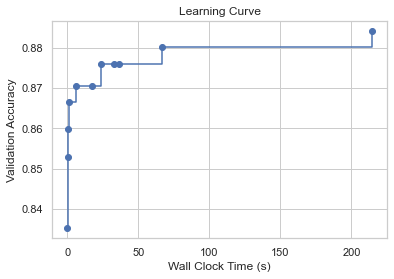

In [110]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

# Default LightGBM

In [111]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()

In [112]:
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)

# Default XGBoost

In [113]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
cat_columns = X_train.select_dtypes(include=['category']).columns
X = X_train.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)


xgb.fit(X, y_train)

X = X_test.copy()
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
y_pred_xgb = xgb.predict(X)


c:\Users\vinhe\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [114]:
print('default xgboost accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_xgb, y_test))
print('default lgbm accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred_lgbm, y_test))
print('flaml (10 min) accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

default xgboost accuracy = 0.875
default lgbm accuracy = 0.8478260869565217
flaml (10 min) accuracy = 0.8858695652173914


In [121]:
automl = AutoML()

settings = {
  "time_budget": 180, # seconds
  "metric": 'accuracy',
  "task": 'classification',
  "verbose": 0,
  "estimator_list": ["lgbm", "catboost", "xgboost", "rf", "extra_tree"],
  "n_jobs": -1,
  "eval_method": "cv",
  "n_splits": 5,
  "seed" : 100
  }

In [122]:
automl.fit(X_train, y_train, **settings)

In [123]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 12, 'num_leaves': 4, 'min_child_samples': 16, 'learning_rate': 0.4658444348772689, 'log_max_bin': 10, 'colsample_bytree': 0.9142764429946194, 'reg_alpha': 0.058542224940530053, 'reg_lambda': 0.371862776209723}
Best accuracy on validation data: 0.8815
Training duration of best run: 0.009002 s
